In [29]:
import numpy
import pandas
import keras
from matplotlib import pyplot
import seaborn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
import pathlib
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [30]:
# CLASSIFIER PARAMETERS
my_vars = ['petallength', 'petalwidth', 'sepallength', 'sepalwidth'] # 'sepallength', 'sepalwidth', 'petallength', 'petalwidth'
class_col = 'flower'

# TRAINING PARAMETERS
max_hidden_neurons = 4
hidden_neuron_activation = 'tanh' # 'tanh', 'relu', 'sigmoid'
my_metric = 'Accuracy' # 'Precision', 'Recall', 'Accuracy'
min_improvement = 0.01
my_patience = 250
base_max_epoch = 10*my_patience
optimizer_name = 'rmsprop' # 'sgd', 'adam', 'rmsprop'
lr = 0.005
n_k_folds = 5
batch_size = 128
hyperconfig_stat = 'mean' # 'mean', 'median', 'max', 'min'
relevant_features = 2


# CONTROL RANDOMNESS
random_seed = 33

In [31]:
# SET THE RANDOM SEED
keras.utils.set_random_seed(random_seed)

In [32]:
# BUILD PATH TO DATA USING PATHLIB
this_folder = pathlib.Path.cwd()
data_folder = this_folder.parent.parent
path_to_iris = data_folder / 'datasets' / 'iris.data'
my_vars_w_class = my_vars.copy()
my_vars_w_class.append(class_col)
iris = pandas.read_csv(path_to_iris, sep=',', decimal='.')
iris = iris[my_vars_w_class]
iris

,petallength,petalwidth,sepallength,sepalwidth,flower
0,1.4,0.2,5.1,3.5,Iris-setosa
1,1.4,0.2,4.9,3.0,Iris-setosa
2,1.3,0.2,4.7,3.2,Iris-setosa
3,1.5,0.2,4.6,3.1,Iris-setosa
4,1.4,0.2,5.0,3.6,Iris-setosa
...,...,...,...,...,...
145,5.2,2.3,6.7,3.0,Iris-virginica
146,5.0,1.9,6.3,2.5,Iris-virginica
147,5.2,2.0,6.5,3.0,Iris-virginica
148,5.4,2.3,6.2,3.4,Iris-virginica


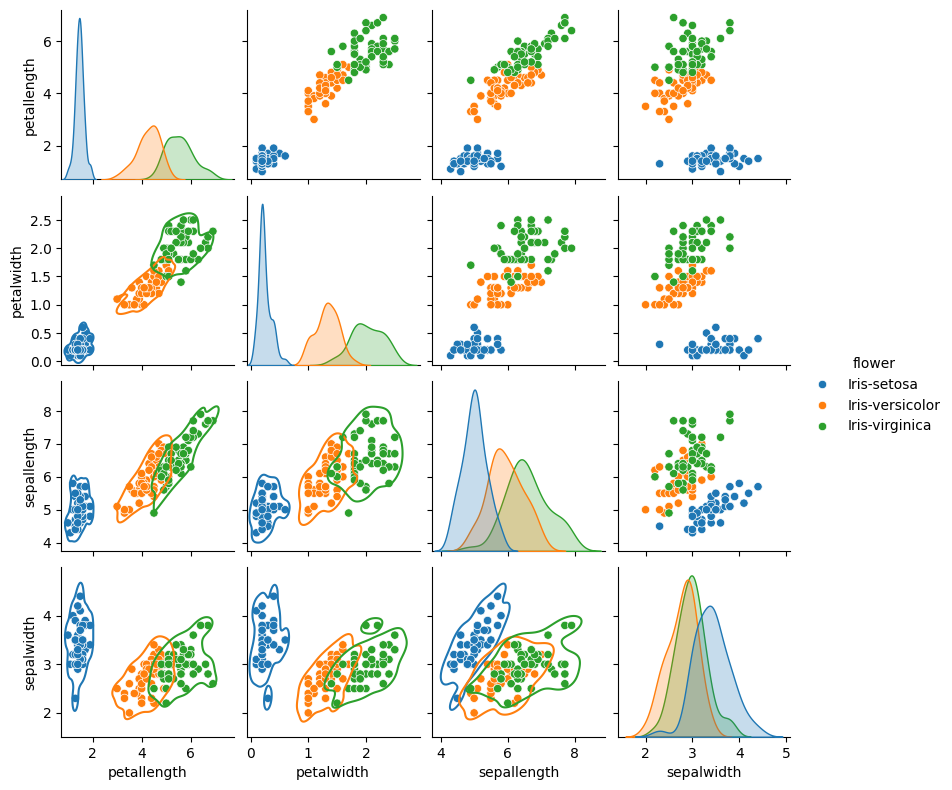

In [33]:
# SCATTER PLOT
_ = g = seaborn.pairplot(iris, hue='flower', height=2, diag_kind='kde')
_ = g.map_lower(seaborn.kdeplot, levels=1, color=".2")

In [34]:
# BASE TRAINING LOOP
my_vars = list(iris.columns[iris.columns != class_col])
df_X = iris[my_vars]
one_hot = OneHotEncoder(sparse_output=False)
df_Y_categorical = iris[[class_col]]
Y_array_categorical = df_Y_categorical.to_numpy()
one_hot.fit(Y_array_categorical)
df_Y = pandas.DataFrame(one_hot.transform(Y_array_categorical))
df_Y.columns = one_hot.categories_
n_classes = df_Y.columns.shape[0]

# PREPARE DATA
X = df_X.to_numpy()
Y = df_Y.to_numpy()

# NORMALIZE VARIABLES
X_scaler = StandardScaler()
X_scaler = X_scaler.fit(X)
X_scaled = X_scaler.transform(X)

# GET STRATIFIED FOLDS
sk_folds = StratifiedKFold(n_splits=n_k_folds)
sk_folds.get_n_splits(X_scaled, Y_array_categorical)

# TRAINING LOOP
result_list = []
for n_neuron in numpy.arange(1, max_hidden_neurons+1):
    ix_fold = 1
    for train_index, validation_index in sk_folds.split(X_scaled, Y_array_categorical):
        X_train, X_val = X_scaled[train_index], X_scaled[validation_index]
        Y_train, Y_val = Y[train_index], Y[validation_index]
        
        # DECLARE NET
        inputs = keras.Input(shape=(len(my_vars), ))
        hidden = keras.layers.Dense(n_neuron, activation=hidden_neuron_activation)(inputs)
        bnorm = keras.layers.BatchNormalization()(hidden)
        outputs = keras.layers.Dense(n_classes, activation='softmax')(bnorm)
        model_name = f'{optimizer_name.upper()}-{hidden_neuron_activation.upper()}-N{n_neuron}F{ix_fold}'
        my_net = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
        val_metric_name = 'val_{}'.format(my_metric)

        match optimizer_name:
            case 'sgd':
                optimizer = keras.optimizers.SGD(learning_rate=lr)
            case 'adam':
                optimizer = keras.optimizers.Adam(learning_rate=lr)
            case 'rmsprop':
                optimizer = keras.optimizers.RMSprop(learning_rate=lr)
            case _:
                raise ValueError(f'Optimizer {optimizer_name} not recognized')

        my_net.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[my_metric])
        es_loss = keras.callbacks.EarlyStopping(monitor='val_loss', patience=my_patience, restore_best_weights=True)
        es_metric = keras.callbacks.EarlyStopping(monitor=my_metric, mode='max', patience=my_patience, min_delta=min_improvement, restore_best_weights=True)
        
        # FIT
        history = my_net.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=X_train.shape[0], epochs=base_max_epoch, verbose=0, callbacks=[es_loss, es_metric])
        
        # UNPACK TRAINING RESULTS
        model_loss = history.history['loss'][-1]
        model_val_loss = history.history['val_loss'][-1]
        metric_val = history.history[my_metric][-1]
        val_metric_val = history.history[val_metric_name][-1]
        n_epochs = len(history.history['val_loss'])
        result_dict = {'model_name': model_name,
                       'optimizer_name' : optimizer_name,
                       'neurons': n_neuron,
                       'fold': ix_fold,
                       'loss': model_loss,
                       'val_loss': model_val_loss,
                       my_metric: metric_val,
                       val_metric_name: val_metric_val,
                       'epochs': n_epochs,
                       'net': my_net,
                       'history': history}
        result_list.append(result_dict)
        print(f'{model_name} > epochs: {n_epochs} loss: {model_loss:.2f} val_loss: {model_val_loss:.2f} {my_metric}: {100.0*metric_val:.0f}% {val_metric_name}: {100.0*val_metric_val:.0f}%')
        ix_fold += 1 

RMSPROP-TANH-N1F1 > epochs: 440 loss: 0.12 val_loss: 1.02 Accuracy: 96% val_Accuracy: 63%
RMSPROP-TANH-N1F2 > epochs: 508 loss: 0.07 val_loss: 1.34 Accuracy: 97% val_Accuracy: 70%
RMSPROP-TANH-N1F3 > epochs: 484 loss: 0.07 val_loss: 0.33 Accuracy: 98% val_Accuracy: 83%
RMSPROP-TANH-N1F4 > epochs: 636 loss: 0.03 val_loss: 2.19 Accuracy: 100% val_Accuracy: 67%
RMSPROP-TANH-N1F5 > epochs: 416 loss: 0.09 val_loss: 0.77 Accuracy: 98% val_Accuracy: 67%
RMSPROP-TANH-N2F1 > epochs: 498 loss: 0.05 val_loss: 0.03 Accuracy: 98% val_Accuracy: 97%
RMSPROP-TANH-N2F2 > epochs: 347 loss: 0.05 val_loss: 0.01 Accuracy: 98% val_Accuracy: 100%
RMSPROP-TANH-N2F3 > epochs: 513 loss: 0.03 val_loss: 0.14 Accuracy: 99% val_Accuracy: 93%
RMSPROP-TANH-N2F4 > epochs: 429 loss: 0.01 val_loss: 0.21 Accuracy: 100% val_Accuracy: 93%
RMSPROP-TANH-N2F5 > epochs: 590 loss: 0.05 val_loss: 0.25 Accuracy: 98% val_Accuracy: 97%
RMSPROP-TANH-N3F1 > epochs: 493 loss: 0.03 val_loss: 0.01 Accuracy: 99% val_Accuracy: 100%
RMSPRO

In [35]:
df_results = pandas.DataFrame(result_list)

df_results.sort_values(by=[f'val_{my_metric}', my_metric, 'neurons'], ascending=[False, False, True])

,model_name,optimizer_name,neurons,fold,loss,val_loss,Accuracy,val_Accuracy,epochs,net,history
10,RMSPROP-TANH-N3F1,rmsprop,3,1,0.025770,0.013798,0.991667,1.000000,493,"<Functional name=RMSPROP-TANH-N3F1, built=True>",<keras.src.callbacks.history.History object at...
6,RMSPROP-TANH-N2F2,rmsprop,2,2,0.048290,0.006941,0.983333,1.000000,347,"<Functional name=RMSPROP-TANH-N2F2, built=True>",<keras.src.callbacks.history.History object at...
5,RMSPROP-TANH-N2F1,rmsprop,2,1,0.046875,0.031392,0.983333,0.966667,498,"<Functional name=RMSPROP-TANH-N2F1, built=True>",<keras.src.callbacks.history.History object at...
9,RMSPROP-TANH-N2F5,rmsprop,2,5,0.046980,0.254820,0.983333,0.966667,590,"<Functional name=RMSPROP-TANH-N2F5, built=True>",<keras.src.callbacks.history.History object at...
11,RMSPROP-TANH-N3F2,rmsprop,3,2,0.035285,0.103044,0.983333,0.966667,467,"<Functional name=RMSPROP-TANH-N3F2, built=True>",<keras.src.callbacks.history.History object at...
14,RMSPROP-TANH-N3F5,rmsprop,3,5,0.031071,0.155247,0.983333,0.966667,418,"<Functional name=RMSPROP-TANH-N3F5, built=True>",<keras.src.callbacks.history.History object at...
15,RMSPROP-TANH-N4F1,rmsprop,4,1,0.047506,0.098286,0.983333,0.966667,372,"<Functional name=RMSPROP-TANH-N4F1, built=True>",<keras.src.callbacks.history.History object at...
16,RMSPROP-TANH-N4F2,rmsprop,4,2,0.031694,0.098160,0.983333,0.966667,346,"<Functional name=RMSPROP-TANH-N4F2, built=True>",<keras.src.callbacks.history.History object at...
19,RMSPROP-TANH-N4F5,rmsprop,4,5,0.042486,0.043225,0.983333,0.966667,440,"<Functional name=RMSPROP-TANH-N4F5, built=True>",<keras.src.callbacks.history.History object at...
8,RMSPROP-TANH-N2F4,rmsprop,2,4,0.007178,0.206445,1.000000,0.933333,429,"<Functional name=RMSPROP-TANH-N2F4, built=True>",<keras.src.callbacks.history.History object at...


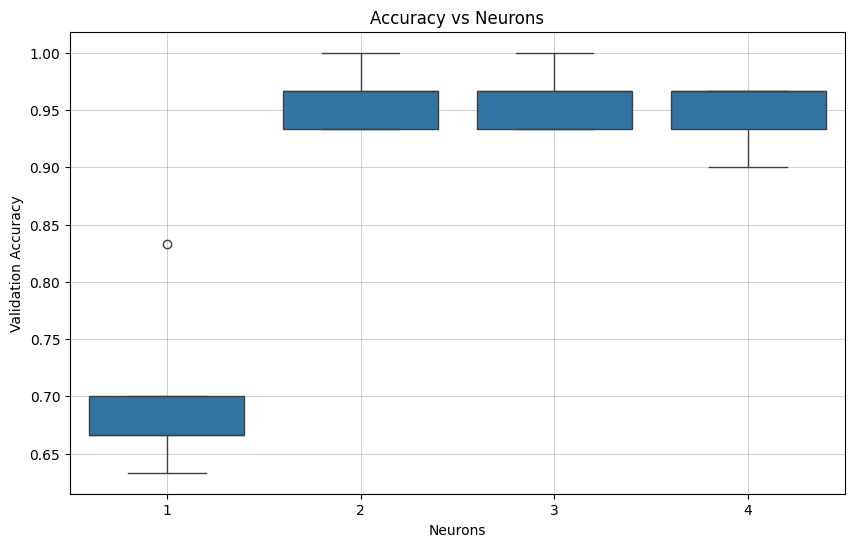

In [36]:
# BOXPLOT VAL METRIC VS NEURONS
fig = pyplot.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
_ = seaborn.boxplot(x='neurons', y=f'val_{my_metric}', data=df_results, ax=ax)
_ = ax.set_title(f'{my_metric} vs Neurons')
_ = ax.set_xlabel('Neurons')
_ = ax.set_ylabel(f'Validation {my_metric}')
_ = ax.grid(which='major', linestyle='-', linewidth='0.5', color='gray', alpha=0.5)


In [37]:
# AGGREGATE BY NEURONS AND OPTIMIZER
df_results_agg = df_results.groupby(['neurons', 'optimizer_name']).agg({f'val_{my_metric}': ['mean', 'std', 'min', 'max']}).reset_index()
df_results_agg.columns = ['neurons', 'optimizer_name', 'mean', 'std', 'min', 'max']
df_results_agg = df_results_agg.sort_values(by=[hyperconfig_stat, 'neurons'], ascending=[False, True])
df_results_agg

,neurons,optimizer_name,mean,std,min,max
1,2,rmsprop,0.960000,0.027889,0.933333,1.000000
2,3,rmsprop,0.960000,0.027889,0.933333,1.000000
3,4,rmsprop,0.946667,0.029814,0.900000,0.966667
0,1,rmsprop,0.700000,0.078174,0.633333,0.833333


In [38]:
best_hyperconfig = df_results_agg.iloc[0]
best_neurons = int(best_hyperconfig['neurons'])
best_optimizer_name = best_hyperconfig['optimizer_name']
best_hyperconfig

neurons                  2
optimizer_name     rmsprop
mean                  0.96
std               0.027889
min               0.933333
max                    1.0
Name: 1, dtype: object

In [39]:
best_rows = df_results[(df_results.neurons == best_neurons) & (df_results.optimizer_name == best_optimizer_name)]
best_net_name = best_rows['model_name'].values[0]
best_optimizer_name = best_rows['optimizer_name'].values[0]
best_net = best_rows['net'].values[0]
best_neurons = best_rows['neurons'].values[0]
best_metric = best_rows[my_metric].values[0]
best_metric_val = best_rows[val_metric_name].values[0]
best_history = best_rows['history'].values[0]
best_epochs = best_rows['epochs'].values[0]

best_rows


,model_name,optimizer_name,neurons,fold,loss,val_loss,Accuracy,val_Accuracy,epochs,net,history
5,RMSPROP-TANH-N2F1,rmsprop,2,1,0.046875,0.031392,0.983333,0.966667,498,"<Functional name=RMSPROP-TANH-N2F1, built=True>",<keras.src.callbacks.history.History object at...
6,RMSPROP-TANH-N2F2,rmsprop,2,2,0.048290,0.006941,0.983333,1.000000,347,"<Functional name=RMSPROP-TANH-N2F2, built=True>",<keras.src.callbacks.history.History object at...
7,RMSPROP-TANH-N2F3,rmsprop,2,3,0.031559,0.138719,0.991667,0.933333,513,"<Functional name=RMSPROP-TANH-N2F3, built=True>",<keras.src.callbacks.history.History object at...
8,RMSPROP-TANH-N2F4,rmsprop,2,4,0.007178,0.206445,1.000000,0.933333,429,"<Functional name=RMSPROP-TANH-N2F4, built=True>",<keras.src.callbacks.history.History object at...
9,RMSPROP-TANH-N2F5,rmsprop,2,5,0.046980,0.254820,0.983333,0.966667,590,"<Functional name=RMSPROP-TANH-N2F5, built=True>",<keras.src.callbacks.history.History object at...


In [40]:
# CALCULATE VARIABLE RELEVANCE USING THE BEST NET
Y_est = best_net.predict(X_scaled, verbose=0)
relevance_dict = {}
for feature in my_vars:
    X_relevance = numpy.copy(X_scaled)
    X_relevance[:, df_X.columns == feature] = 0.0
    Y_est_relevance = best_net.predict(X_relevance, verbose=0)
    Y_relevance = (Y_est - Y_est_relevance)**2
    feature_relevance = Y_relevance.sum()/Y_relevance.shape[0]
    relevance_dict[feature] = feature_relevance
s_relevance = pandas.Series(relevance_dict)
s_relevance_norm = s_relevance/s_relevance.max()
s_relevance_norm = s_relevance_norm.sort_values(ascending=False).head(relevant_features)
selected_features = list(s_relevance_norm.index.values)
selected_relevance = list(100.0*s_relevance_norm.values)
df_relevance = pandas.DataFrame({'feature': selected_features, 'relevance': selected_relevance})

In [41]:
df_relevance

,feature,relevance
0,petallength,100.000000
1,petalwidth,84.737709


In [42]:
# RETRAIN THE NET USING ONLY THE RELEVANT FEATURES
X_relevant = df_X[selected_features].to_numpy()

# GET STRATIFIED FOLDS
sk_folds = StratifiedKFold(n_splits=n_k_folds)
sk_folds.get_n_splits(X_relevant, Y_array_categorical)

# TRAINING LOOP
result_list = []
for n_layers in numpy.arange(1, best_neurons+1):
    for n_neuron in numpy.arange(1, best_neurons+1):
        ix_fold = 1
        for train_index, validation_index in sk_folds.split(X_relevant, Y_array_categorical):
            X_train, X_val = X_relevant[train_index], X_relevant[validation_index]
            Y_train, Y_val = Y[train_index], Y[validation_index]
            
            # DECLARE NET
            inputs = keras.Input(shape=(len(selected_features), ))
            hidden = keras.layers.Dense(n_neuron, activation=hidden_neuron_activation)(inputs)
            hidden = keras.layers.BatchNormalization()(hidden)
            if n_layers > 1:
                for _ in range(n_layers-1):
                    hidden = keras.layers.Dense(n_layers, activation=hidden_neuron_activation)(hidden)
                    hidden = keras.layers.BatchNormalization()(hidden)

            outputs = keras.layers.Dense(n_classes, activation='softmax')(hidden)
            model_name = f'{optimizer_name.upper()}-{hidden_neuron_activation.upper()}-L{n_layers}N{n_neuron}F{ix_fold}'
            my_net = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
            val_metric_name = 'val_{}'.format(my_metric)

            match optimizer_name:
                case 'sgd':
                    optimizer = keras.optimizers.SGD(learning_rate=lr)
                case 'adam':
                    optimizer = keras.optimizers.Adam(learning_rate=lr)
                case 'rmsprop':
                    optimizer = keras.optimizers.RMSprop(learning_rate=lr)
                case _:
                    raise ValueError(f'Optimizer {optimizer_name} not recognized')

            my_net.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[my_metric])
            es_loss = keras.callbacks.EarlyStopping(monitor='val_loss', patience=my_patience, restore_best_weights=True)
            es_metric = keras.callbacks.EarlyStopping(monitor=my_metric, mode='max', patience=my_patience, min_delta=min_improvement, restore_best_weights=True)
            
            # FIT
            history = my_net.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=X_train.shape[0], epochs=best_epochs, verbose=0, callbacks=[es_loss, es_metric])
            
            # UNPACK TRAINING RESULTS
            model_loss = history.history['loss'][-1]
            model_val_loss = history.history['val_loss'][-1]
            metric_val = history.history[my_metric][-1]
            val_metric_val = history.history[val_metric_name][-1]
            n_epochs = len(history.history['val_loss'])
            result_dict = {'model_name': model_name,
                            'optimizer_name' : optimizer_name,
                            'layers' : n_layers,
                            'neurons': n_neuron,
                            'fold': ix_fold,
                            'loss': model_loss,
                            'val_loss': model_val_loss,
                            my_metric: metric_val,
                            val_metric_name: val_metric_val,
                            'epochs': n_epochs,
                            'net': my_net,
                            'history': history}
            result_list.append(result_dict)
            print(f'{model_name} > epochs: {n_epochs} loss: {model_loss:.2f} val_loss: {model_val_loss:.2f} {my_metric}: {100.0*metric_val:.0f}% {val_metric_name}: {100.0*val_metric_val:.0f}%')
            ix_fold += 1

RMSPROP-TANH-L1N1F1 > epochs: 399 loss: 0.13 val_loss: 0.66 Accuracy: 96% val_Accuracy: 73%
RMSPROP-TANH-L1N1F2 > epochs: 378 loss: 0.15 val_loss: 0.30 Accuracy: 95% val_Accuracy: 83%
RMSPROP-TANH-L1N1F3 > epochs: 415 loss: 0.12 val_loss: 0.86 Accuracy: 98% val_Accuracy: 67%
RMSPROP-TANH-L1N1F4 > epochs: 498 loss: 0.15 val_loss: 1.14 Accuracy: 97% val_Accuracy: 53%
RMSPROP-TANH-L1N1F5 > epochs: 427 loss: 0.14 val_loss: 1.81 Accuracy: 96% val_Accuracy: 33%
RMSPROP-TANH-L1N2F1 > epochs: 376 loss: 0.07 val_loss: 0.26 Accuracy: 96% val_Accuracy: 93%
RMSPROP-TANH-L1N2F2 > epochs: 332 loss: 0.08 val_loss: 0.15 Accuracy: 96% val_Accuracy: 97%
RMSPROP-TANH-L1N2F3 > epochs: 413 loss: 0.06 val_loss: 0.12 Accuracy: 97% val_Accuracy: 97%
RMSPROP-TANH-L1N2F4 > epochs: 330 loss: 0.07 val_loss: 0.37 Accuracy: 97% val_Accuracy: 87%
RMSPROP-TANH-L1N2F5 > epochs: 319 loss: 0.09 val_loss: 0.16 Accuracy: 95% val_Accuracy: 90%
RMSPROP-TANH-L2N1F1 > epochs: 358 loss: 0.07 val_loss: 1.12 Accuracy: 97% val_Ac

In [43]:
df_final_results = pandas.DataFrame(result_list)

In [44]:
# AGGREGATE BY NEURONS AND OPTIMIZER
df_final_results_agg = df_final_results.groupby(['neurons', 'optimizer_name']).agg({f'val_{my_metric}': ['mean', 'std', 'min', 'max']}).reset_index()
df_final_results_agg.columns = ['neurons', 'optimizer_name', 'mean', 'std', 'min', 'max']
df_final_results_agg = df_final_results_agg.sort_values(by=[hyperconfig_stat, 'neurons'], ascending=[False, True])
df_final_results_agg

,neurons,optimizer_name,mean,std,min,max
1,2,rmsprop,0.896667,0.079271,0.766667,0.966667
0,1,rmsprop,0.736667,0.212248,0.333333,1.000000


In [45]:
best_final_hyperconfig = df_final_results_agg.iloc[0]
best_final_neurons = int(best_final_hyperconfig['neurons'])
best_final_optimizer_name = best_final_hyperconfig['optimizer_name']
best_final_hyperconfig

neurons                  2
optimizer_name     rmsprop
mean              0.896667
std               0.079271
min               0.766667
max               0.966667
Name: 1, dtype: object

In [46]:
best_final_rows = df_final_results[(df_final_results.neurons == best_final_neurons) & (df_final_results.optimizer_name == best_final_optimizer_name)]
best_final_net_name = best_final_rows['model_name'].values[0]
best_final_optimizer_name = best_final_rows['optimizer_name'].values[0]
best_final_net = best_final_rows['net'].values[0]
best_final_neurons = best_final_rows['neurons'].values[0]
best_final_metric = best_final_rows[my_metric].values[0]
best_final_metric_val = best_final_rows[val_metric_name].values[0]
best_final_history = best_final_rows['history'].values[0]
best_final_epochs = best_final_rows['epochs'].values[0]

best_final_rows

,model_name,optimizer_name,layers,neurons,fold,loss,val_loss,Accuracy,val_Accuracy,epochs,net,history
5,RMSPROP-TANH-L1N2F1,rmsprop,1,2,1,0.071927,0.258494,0.958333,0.933333,376,"<Functional name=RMSPROP-TANH-L1N2F1, built=True>",<keras.src.callbacks.history.History object at...
6,RMSPROP-TANH-L1N2F2,rmsprop,1,2,2,0.082378,0.150408,0.958333,0.966667,332,"<Functional name=RMSPROP-TANH-L1N2F2, built=True>",<keras.src.callbacks.history.History object at...
7,RMSPROP-TANH-L1N2F3,rmsprop,1,2,3,0.061217,0.119877,0.966667,0.966667,413,"<Functional name=RMSPROP-TANH-L1N2F3, built=True>",<keras.src.callbacks.history.History object at...
8,RMSPROP-TANH-L1N2F4,rmsprop,1,2,4,0.074173,0.370129,0.966667,0.866667,330,"<Functional name=RMSPROP-TANH-L1N2F4, built=True>",<keras.src.callbacks.history.History object at...
9,RMSPROP-TANH-L1N2F5,rmsprop,1,2,5,0.090674,0.162919,0.950000,0.900000,319,"<Functional name=RMSPROP-TANH-L1N2F5, built=True>",<keras.src.callbacks.history.History object at...
15,RMSPROP-TANH-L2N2F1,rmsprop,2,2,1,0.065590,0.144466,0.966667,0.966667,297,"<Functional name=RMSPROP-TANH-L2N2F1, built=True>",<keras.src.callbacks.history.History object at...
16,RMSPROP-TANH-L2N2F2,rmsprop,2,2,2,0.075499,0.076885,0.958333,0.966667,493,"<Functional name=RMSPROP-TANH-L2N2F2, built=True>",<keras.src.callbacks.history.History object at...
17,RMSPROP-TANH-L2N2F3,rmsprop,2,2,3,0.048265,0.279070,0.975000,0.866667,310,"<Functional name=RMSPROP-TANH-L2N2F3, built=True>",<keras.src.callbacks.history.History object at...
18,RMSPROP-TANH-L2N2F4,rmsprop,2,2,4,0.063852,1.220635,0.966667,0.766667,309,"<Functional name=RMSPROP-TANH-L2N2F4, built=True>",<keras.src.callbacks.history.History object at...
19,RMSPROP-TANH-L2N2F5,rmsprop,2,2,5,0.086859,0.534257,0.950000,0.766667,308,"<Functional name=RMSPROP-TANH-L2N2F5, built=True>",<keras.src.callbacks.history.History object at...


In [47]:
if best_final_metric_val > best_metric_val:
    selected_net = best_final_net
    selected_net_name = best_final_net_name
    selected_neurons = best_final_neurons
    selected_optimizer_name = best_final_optimizer_name
    selected_metric = best_final_metric
    selected_metric_val = best_final_metric_val
    selected_history = best_final_history
    selected_epochs = best_final_epochs
    selected_df_results = df_final_results
    final_is_better = True
    print('Final model is better than the original model')
else:
    selected_net = best_net
    selected_net_name = best_net_name
    selected_neurons = best_neurons
    selected_optimizer_name = best_optimizer_name
    selected_metric = best_metric
    selected_metric_val = best_metric_val
    selected_history = best_history
    selected_epochs = best_epochs
    selected_df_results = df_results
    final_is_better = False
    print('Original model is better than the final model')

Original model is better than the final model


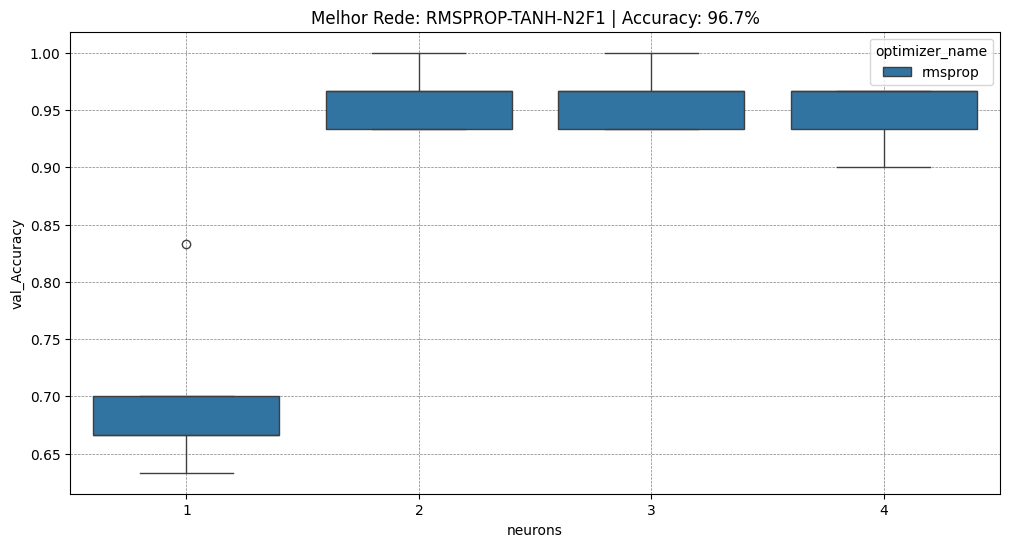

In [48]:
# DRAW A BOXPLOT OF THE RESULTS, GROUPING BY NEURONS AND OPTIMIZER
fig = pyplot.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
_ = seaborn.boxplot(data=selected_df_results, x='neurons', y=f'val_{my_metric}', hue='optimizer_name', ax=ax)
_ = ax.set_title(f'Melhor Rede: {selected_net_name} | {my_metric}: {100.0*selected_metric_val:.1f}%')
_ = ax.grid(which='major', linestyle='--', linewidth='0.5', color='gray')

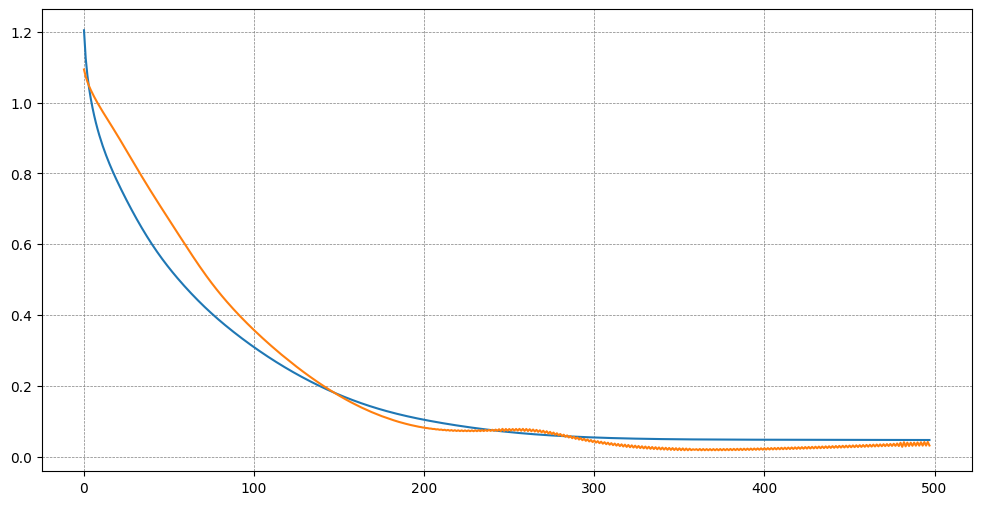

In [49]:
# PLOT TRAINING HISTORY
fig = pyplot.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
_ = ax.plot(selected_history.history['loss'], label='loss')
_ = ax.plot(selected_history.history['val_loss'], label='val_loss')
_ = ax.grid(which='major', linestyle='--', linewidth='0.5', color='gray')

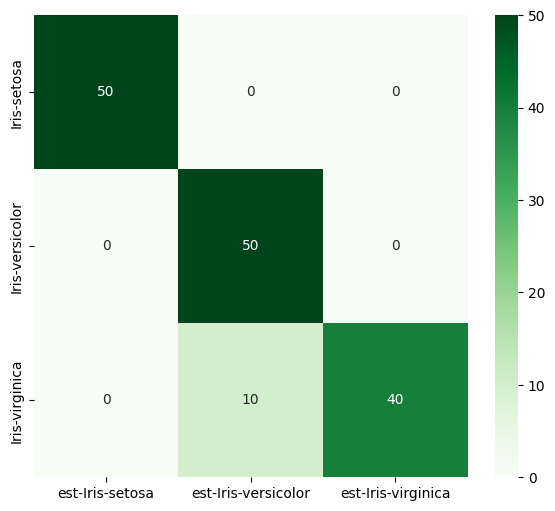

In [50]:
my_classes = [x[0] for x in df_Y.columns.values]
if final_is_better:
    Y_est = selected_net.predict(X_scaled[:, df_X.columns.isin(selected_features)], verbose=0)
else:
    Y_est = selected_net.predict(X_scaled, verbose=0)
Y_class_est = numpy.array([df_Y.columns[x][0] for x in numpy.argmax(Y_est, axis=1)])
my_conf = confusion_matrix(df_Y_categorical[class_col].to_numpy(), Y_class_est, labels=my_classes)
df_conf = pandas.DataFrame(my_conf, index=my_classes, columns=['est-{}'.format(x) for x in my_classes])
# df_conf = pandas.DataFrame(100.0*my_conf/my_conf.sum(axis=0), index=['est-{}'.format(x) for x in my_classes], columns=my_classes)

fig, ax = pyplot.subplots(figsize=(7,6)) 
_ = seaborn.heatmap(df_conf, cmap="Greens", ax=ax, annot=True, fmt='.0f')